# Bring Your Own Model SageMaker 실습
- Local에서 학습한 XGBoost 모델을 이용해 SageMaker Endpoint deploying을 하는 방법

# 작업 1: 사용한 데이터와 목표의 이해



# 소매점 매출 예측 Linear Regression

- 내용
    - 서로 다른 지역에 위치한 45개 매장의 역사적 판매 데이터가 제공됩니다. 각 매장에는 여러 개의 부서가 있습니다. 이 회사는 또한 일 년 내내 몇 차례 프로모션 마크다운 행사를 진행합니다. 이러한 마크다운은 슈퍼보울, 노동절, 추수감사절, 크리스마스와 같은 주요 공휴일 전에 실시됩니다. 이러한 공휴일이 포함된 주는 비공휴일 주보다 평가 시 5배 더 높은 가중치가 부여됩니다. 목표는 어떤 부서에 어느 정도 영향을 미칠지 예측하는 것입니다.

## 프로젝트 개요
45개 매장의 역사적 판매 데이터를 활용하여 다음을 수행합니다:
- **각 매장의 다음 연도 부서 전체 매출 예측**
- **휴일 주간 할인이 미치는 영향 모델링**
- **비즈니스에 가장 큰 영향을 주는 요인 파악 및 권장사항 제공**



## 데이터 출처
- https://www.kaggle.com/manjeetsingh/retaildataset

# 작업 2: 데이터셋과 라이브러리 가져오기

In [ ]:
!pip install missingno seaborn

In [192]:
import xgboost as xgb
xgb.__version__

'1.7.6'

In [193]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile


In [194]:
# import the csv files using pandas 
feature = pd.read_csv('./data/byom/Features_data_set.csv')
sales = pd.read_csv('./data/byom/sales_data_set.csv')
stores = pd.read_csv('./data/byom/stores_data_set.csv')

## 데이터 세트 설명

### Stores
- 45개 매장에 대한 익명화된 정보 (매장 유형 및 규모)

In [195]:
#  "stores" 데이터프레임에는 매장 유형 및 크기와 같은 45개 매장과 관련된 정보가 포함되어 있습니다.

stores.head(10)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512



### Features
- **Store**: 매장 번호
- **Date**: 주 단위
- **Temperature**: 지역의 평균 온도
- **Fuel_Price**: 지역의 연료 가격
- **MarkDown1-5**: 프로모션 할인(가격인하) 관련 익명화된 데이터 (2011년 11월 이후에만 사용 가능, 모든 매장에서 사용되지 않음)
- **CPI**: 소비자 물가 지수
- **Unemployment**: 실업률
- **IsHoliday**: 해당 주가 특별 휴일 주인지 여부

In [5]:
feature

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,28/06/2013,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,05/07/2013,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,12/07/2013,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,19/07/2013,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


### Sales
- **Store**: 매장 번호
- **Dept**: 부서 번호
- **Date**: 주
- **Weekly_Sales**: 해당 매장의 해당 부서 매출  <--- 이걸 찾아봐야겠죠?
- **IsHoliday**: 주가 특별 휴일 주인지 여부

In [6]:
sales

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False
...,...,...,...,...,...
421565,45,98,28/09/2012,508.37,False
421566,45,98,05/10/2012,628.10,False
421567,45,98,12/10/2012,1061.02,False
421568,45,98,19/10/2012,760.01,False


# 작업 3: 개별 dataset 정보 탐색

- 최대 fuel price, 최대 unemployment numbers
- 평균 stores 사이즈


In [7]:
print(sales.info())
sales.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None


,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [8]:
print(feature.info())
feature.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB
None


,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [9]:
print(stores.info())
stores.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None


,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [10]:
# 데이터프레임의 'Date' 열을 날짜 형식으로 변환합니다. 날짜 데이터별 시각화와 정렬에 도움이 됩니다.
print(f"이전 타입: {feature['Date'].dtypes}")
feature['Date'] = pd.to_datetime(feature['Date'], format='mixed', dayfirst=True)
sales['Date'] = pd.to_datetime(sales['Date'], format='mixed', dayfirst=True)
print(f"변경된 타입: {feature['Date'].dtypes}")

이전 타입: object
변경된 타입: datetime64[ns]


In [11]:
feature

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [12]:
sales

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


# 작업 4: DATA 전처리 - 병합과 조작

### sales, feature, stores 데이터 프레임을 Date, IsHoliday(공휴일), Store 열을 기반으로 하나의 데이터 프레임으로 합치는 것을 다룹니다.

In [13]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [14]:
feature.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


### dataframe에 salses와 features 병합하기
'Store','Date','IsHoliday'로 join합니다.

In [15]:
df = pd.merge(sales, feature, on = ['Store','Date','IsHoliday'])


In [16]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667


In [17]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [18]:
print(stores.info())
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB
None


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


### dataframe에 남은 store 병합하기
dataframe 421570 행에 store를 left 조인합니다.

In [19]:
df = pd.merge(df, stores, on = ['Store'], how = 'left')


In [20]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [21]:
x = '2010-05-02'
str(x).split('-')

['2010', '05', '02']

### 월 칼럼을 새로 생성해봅니다.
Date열은 년-월-일 로 되어있습니다. dataframe의 월에 해당하는 값을 찾아 새로운 칼럼을 추가합니다.

In [22]:
def get_month(x):
    return int(str(x).split('-')[1])

In [23]:
df['month'] = df['Date'].apply(get_month)

In [24]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,month
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10


# 작업 5: Merged Data 전처리

### 데이터 시각화 결측치 처리 
결측값(missing value)의 개수를 확인

<Axes: >

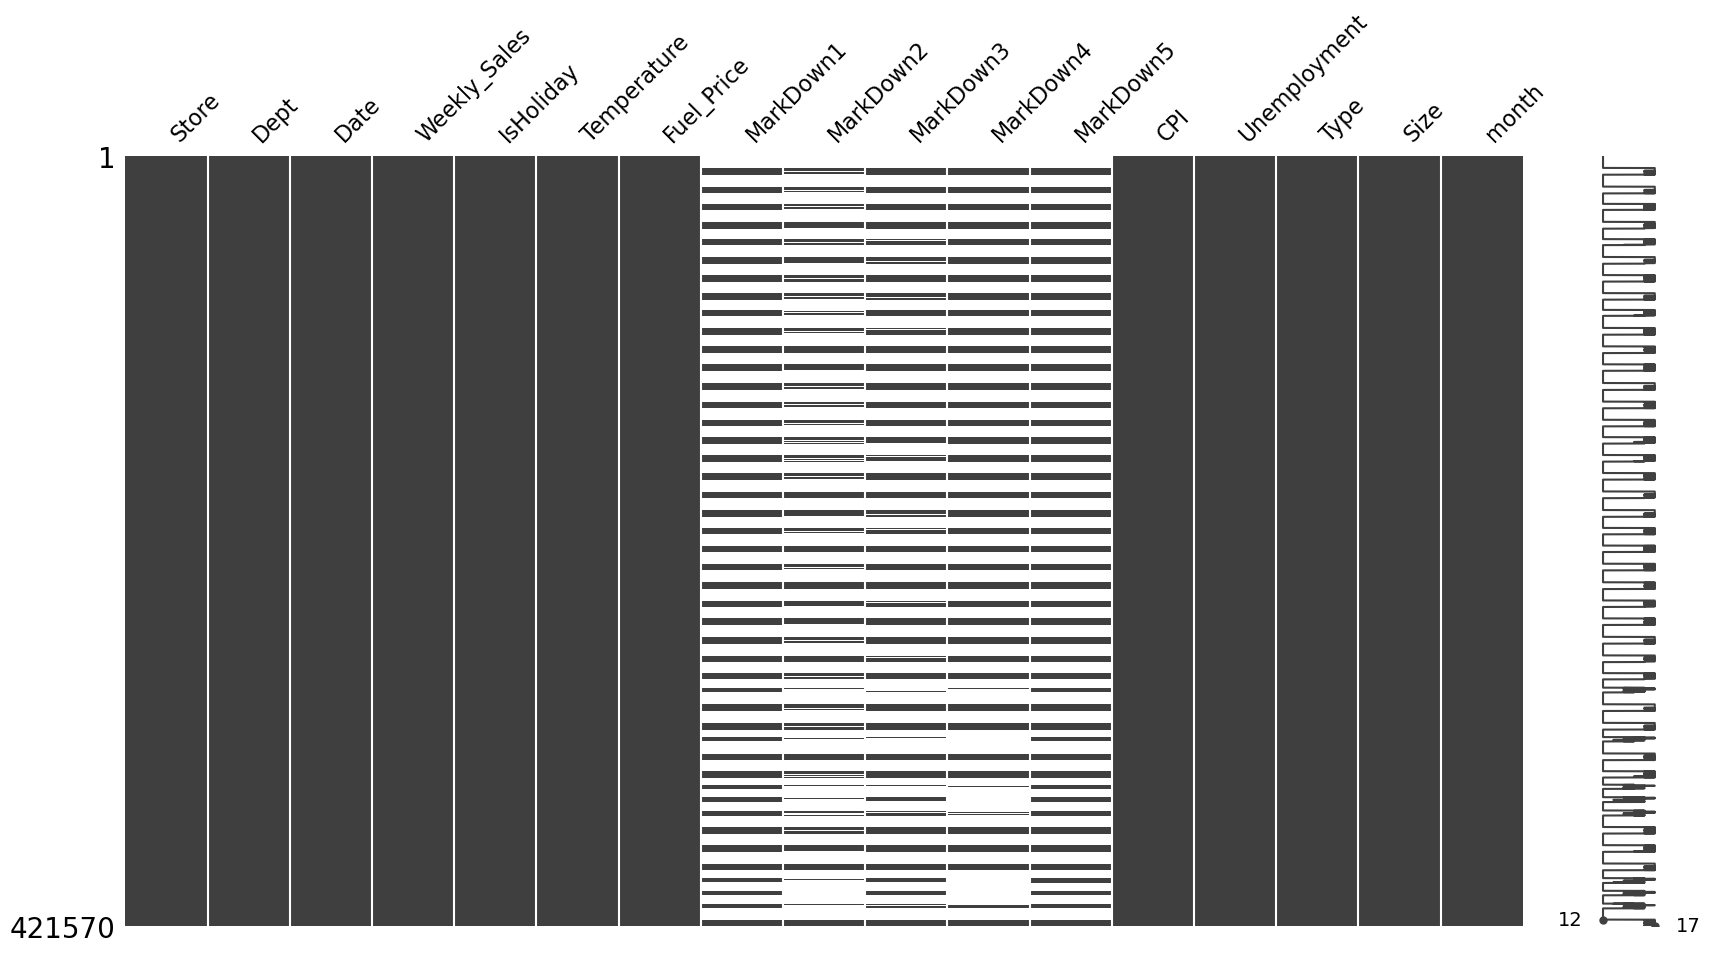

In [25]:
import missingno as msno

msno.matrix(df, figsize=(20,10))

In [26]:
# check the number of null values in the dataframe
df.isnull().sum()


Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
month                0
dtype: int64

### 가격인하가 없는 값은 할인이 0과 같으며 0으로 채웁니다.

In [27]:
# 결측치(NaN, Not a Number)를 0으로 채웁니다.
df = df.fillna(0)


In [28]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,month
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,2
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,2
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,2
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,2
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10


In [29]:
df.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
month           0
dtype: int64

### 결합된 dataframe의 통계 요약

In [30]:
# Statistical summary of the combined dataframe
df.describe()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,month
count,421570.000000,421570.000000,421570,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375360,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,6.449510
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,1.000000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,4.000000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,6.000000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,9.000000
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,12.000000
std,12.785297,30.492054,NaN,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,3.243217


In [31]:
# 중복된 항목이 있는지 확인합니다.
df.duplicated().sum()


0

In [32]:
# Store 타입은 어떤게 있는지 확인해봅니다.
df['Type'].value_counts()

Type
A    215478
B    163495
C     42597
Name: count, dtype: int64

### "IsHoliday"를 True 및 False(숫자가 있는 문자) 대신 1과 0으로 바꿔봅니다.


In [33]:
df['IsHoliday'] = df['IsHoliday'].replace({True:1, False:0})

In [34]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,month
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,2
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,2
2,1,3,2010-02-05,13740.12,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,2
3,1,4,2010-02-05,39954.04,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,2
4,1,5,2010-02-05,32229.38,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10
421566,45,94,2012-10-26,5203.31,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10
421567,45,95,2012-10-26,56017.47,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10
421568,45,97,2012-10-26,6817.48,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,10


# 작업 6: EXPLORATORY DATA ANALYSIS(EDA) 수행

### 주간판매율에 대한 다차원 분석을 위해 날짜(Date), 가게(Store), 부서(Dept)를 행 인덱스로, 유형(A, B, C)을 열로 하는 피봇테이블을 생성하여 유형별 주간판매율 평균을 집계

In [35]:
# Create pivot tables to understand the relationship in the data

result = pd.pivot_table(df, values = 'Weekly_Sales', columns = ['Type'], index = ['Date', 'Store', 'Dept'],
                    aggfunc= 'mean')

In [36]:
result

Type                          A         B   C
Date       Store Dept                        
2010-02-05 1     1     24924.50       NaN NaN
                 2     50605.27       NaN NaN
                 3     13740.12       NaN NaN
                 4     39954.04       NaN NaN
                 5     32229.38       NaN NaN
...                         ...       ...  ..
2012-10-26 45    93         NaN   2487.80 NaN
                 94         NaN   5203.31 NaN
                 95         NaN  56017.47 NaN
                 97         NaN   6817.48 NaN
                 98         NaN   1076.80 NaN

[421570 rows x 3 columns]

In [37]:
result.describe()
# A형 매장이 B형, C형 매장에 비해 주간판매 매출이 훨씬 높은 것을 알 수 있습니다.

Type,A,B,C
count,215478.000000,163495.000000,42597.000000
mean,20099.568043,12237.075977,9519.532538
std,26423.457227,17203.668989,15985.351612
min,-4988.940000,-3924.000000,-379.000000
25%,3315.090000,1927.055000,131.990000
50%,10105.170000,6187.870000,1149.670000
75%,26357.180000,15353.740000,12695.010000
max,474330.100000,693099.360000,112152.350000


In [38]:
# 1번째부터 5번째까지의 가격할인이 공휴일에 어떤 영향이 미쳤는지 알아봅니다.
result_md = pd.pivot_table(df, values=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], 
                           columns=['IsHoliday'], index=['Date', 'Store', 'Dept'],
                           aggfunc={'MarkDown1': 'mean', 'MarkDown2': 'mean', 'MarkDown3': 'mean', 'MarkDown4': 'mean', 'MarkDown5': 'mean'})

In [39]:
result_md

MarkDown1     MarkDown2     MarkDown3     MarkDown4      \
IsHoliday                     0   1         0   1         0   1         0   1   
Date       Store Dept                                                           
2010-02-05 1     1         0.00 NaN      0.00 NaN       0.0 NaN      0.00 NaN   
                 2         0.00 NaN      0.00 NaN       0.0 NaN      0.00 NaN   
                 3         0.00 NaN      0.00 NaN       0.0 NaN      0.00 NaN   
                 4         0.00 NaN      0.00 NaN       0.0 NaN      0.00 NaN   
                 5         0.00 NaN      0.00 NaN       0.0 NaN      0.00 NaN   
...                         ...  ..       ...  ..       ...  ..       ...  ..   
2012-10-26 45    93     4018.91 NaN     58.08 NaN     100.0 NaN    211.94 NaN   
                 94     4018.91 NaN     58.08 NaN     100.0 NaN    211.94 NaN   
                 95     4018.91 NaN     58.08 NaN     100.0 NaN    211.94 NaN   
                 97     4018.91 NaN     58.08 NaN     100.0 NaN    211.94 NaN   
                 98     4018.91 NaN     58.08 NaN     100.0 NaN    211.94 NaN   

                      MarkDown5      
IsHoliday                     0   1  
Date       Store Dept                
2010-02-05 1     1         0.00 NaN  
                 2         0.00 NaN  
                 3         0.00 NaN  
                 4         0.00 NaN  
                 5         0.00 NaN  
...                         ...  ..  
2012-10-26 45    93      858.33 NaN  
                 94      858.33 NaN  
                 95      858.33 NaN  
                 97      858.33 NaN  
                 98      858.33 NaN  

[421570 rows x 10 columns]

In [40]:
result_md.sum()

           IsHoliday
MarkDown1  0            1.017371e+09
           1            7.452684e+07
MarkDown2  0            2.310619e+08
           1            1.399088e+08
MarkDown3  0            2.460332e+07
           1            1.727284e+08
MarkDown4  0            4.196331e+08
           1            3.698298e+07
MarkDown5  0            6.585670e+08
           1            4.240793e+07
dtype: float64

### 가격할인과 공휴일의 상관관계 
- MarkDown2와 MarkDown3는 평균 할인을 보면, 평일에 비해 휴일에 더 많은 볼륨이 있다는 결론을 내릴 수 있습니다.
- 가격할인 1, 4, 5는 공휴일에 따라 큰 변화를 보이지 않습니다

In [41]:
result_md.describe()


MarkDown1                    MarkDown2                 \
IsHoliday              0             1              0              1   
count      391909.000000  29661.000000  391909.000000   29661.000000   
mean         2595.936803   2512.620778     589.580546    4716.929394   
std          6123.402037   5020.047408    2984.163111   15295.329993   
min             0.000000      0.000000    -265.760000      -9.980000   
25%             0.000000      0.000000       0.000000       0.000000   
50%             0.000000      0.000000       0.000000       0.000000   
75%          2826.570000   2463.160000       0.500000      65.000000   
max         88646.760000  36778.650000   45971.430000  104519.540000   

               MarkDown3                     MarkDown4                \
IsHoliday              0              1              0             1   
count      391909.000000   29661.000000  391909.000000  29661.000000   
mean           62.778142    5823.417900    1070.741151   1246.855336   
std           630.704594   19959.302249    3921.553070   3513.998030   
min           -29.100000       0.000000       0.000000      0.000000   
25%             0.000000       0.000000       0.000000      0.000000   
50%             0.000000       0.000000       0.000000      0.000000   
75%             3.840000      66.080000     442.390000    319.190000   
max         25959.980000  141630.610000   67474.850000  29483.810000   

               MarkDown5                
IsHoliday              0             1  
count      391909.000000  29661.000000  
mean         1680.408001   1429.754053  
std          4312.031598   2427.638027  
min             0.000000      0.000000  
25%             0.000000      0.000000  
50%             0.000000      0.000000  
75%          2182.320000   2069.300000  
max        108519.280000  11100.550000

### 상관관계 확인
- 상관관계를 봐도 MarkDown2와 MarkDown3는 휴일에 더 많은 상관관계가 있습니다.
- 할인4(MarkDown4)와 할인1(MarkDown1)은 밀접한 관계가 있습니다.
- 할인5(MarkDown5)와 할인1(MarkDown1)도 관계가 있습니다.

In [42]:
corr_matrix = df.drop(columns=['Store']).corr(numeric_only=True)

<Axes: >

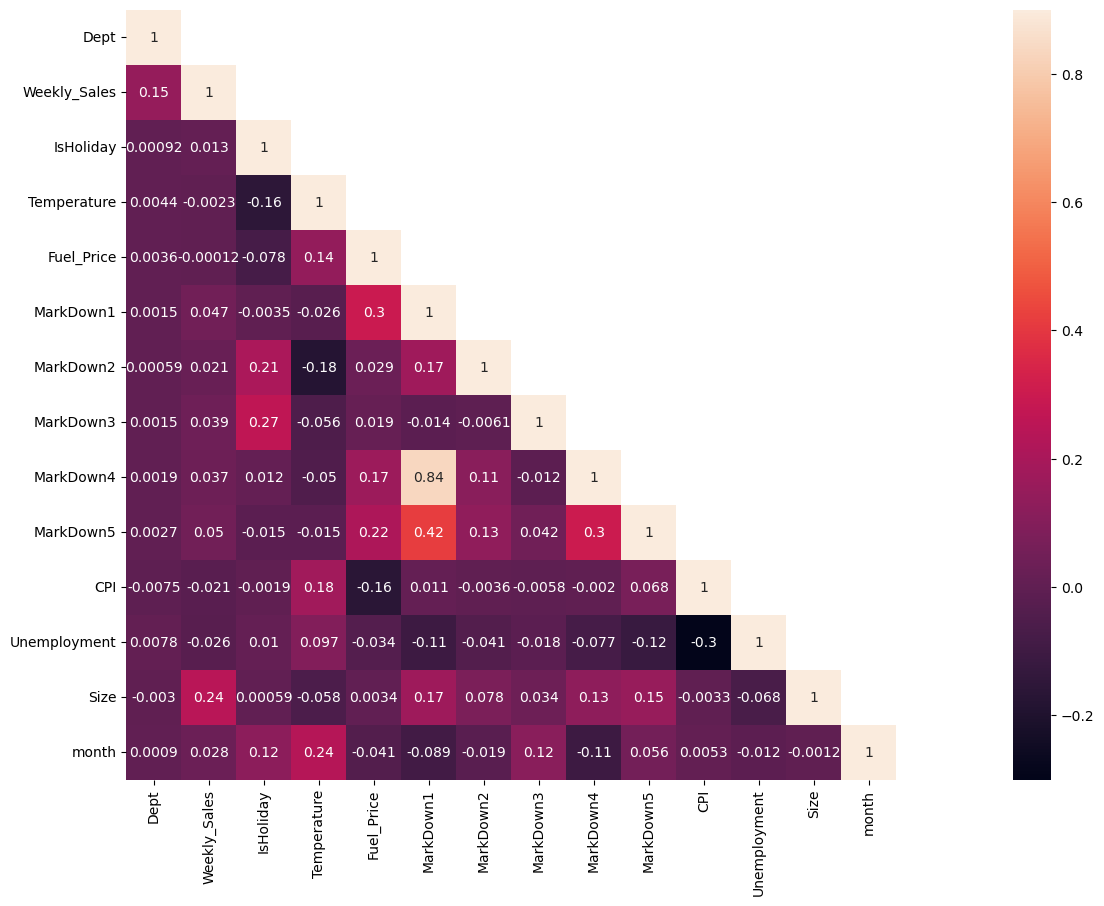

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(30,10)
mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(corr_matrix, mask=mask,vmax=.9, square=True,annot=True)

# 작업 7: Data 시각화 수행

In [ ]:
df

In [ ]:
#df.hist(bins = 30, figsize = (20,20), color = 'r')
import math

# 서브플롯의 행과 열 수 계산
n_cols = 2
n_rows = math.ceil(len(df.columns) / n_cols)  # 올림을 사용하여 정수로 만듦

plt.figure(figsize=(20, 20))
for i, column in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[column], kde=False, color='r', bins=30)
    plt.title(column)

plt.tight_layout()
plt.show()


In [ ]:
# seaborn 스타일 설정
sns.set_style("darkgrid")

# 그래프 크기 설정
plt.figure(figsize=(10, 8))

# 히스토그램 그리기
sns.histplot(data=df, bins=30, kde=True, color='r')

# 제목 설정
plt.title("Histogram of Data")
# x축 레이블 설정
plt.xlabel("Value")
# y축 레이블 설정
plt.ylabel("Count")
# 그래프 표시
plt.show()

### 칼럼간의 분포관계를 pairplot으로 확인합니다.
- 이작업은 5분정도 걸립니다. 

In [ ]:
sns.pairplot(df[["Weekly_Sales","IsHoliday","MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5","Type","month"]], diag_kind = "kde")

In [ ]:
df_type = df.groupby('Type').mean()

In [ ]:
df_type

### Type유형별 주간 매출 시각화

In [ ]:
# 스타일 설정
sns.set_style("whitegrid")

# 팔레트 설정
palette = ["#FF6347", "#40E0D0", "#FFA500"]  # 원하는 색상 코드 입력

# 그래프 그리기
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="Type", y="Weekly_Sales", data=df, ax=ax, palette=palette, hue="Type", legend=False)

# x축 레이블 회전
plt.xticks(rotation=45)

# 그래프 제목 추가
plt.title("Weekly Sales by Type", fontsize=16)

# 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [ ]:
# df_dept = df.drop(columns = ['Store','Type','IsHoliday','Temperature','Fuel_Price','CPI','Unemployment','Size','month'])
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_dept = df[numeric_cols].groupby('Dept').mean()
df_dept

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_barh(data, column, title, color_palette):
    """
    가로 바 차트를 그리는 함수
    
    Parameters:
    data (pandas.DataFrame): 데이터프레임
    column (str): 열 이름
    title (str): 그래프 제목
    color_palette (str): 색상 팔레트 이름
    
    Returns:
    None
    """
    
    # 그래프 스타일 설정
    sns.set_style("whitegrid")
    
    # 가로 바 차트 그리기
    fig, ax = plt.subplots(figsize=(14, 16))
    sns.barplot(x=column, y=data.index, data=data, hue=data.index, palette=color_palette, orient='h', legend=False)
    
    # 제목, 축 레이블 설정
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(column, fontsize=14)
    ax.set_ylabel('Department', fontsize=14)
    
    # Y축 레이블 회전
    plt.xticks(rotation=45, ha='right')
    
    # 그리드 표시
    ax.grid(True)
    
    # 여백 조정
    plt.subplots_adjust(left=0.3)
    plt.tight_layout()
    
    # 그래프 표시
    plt.show()

In [ ]:
plot_barh(data=df_dept, column='Weekly_Sales', title='Weekly Sales by Department', color_palette="rocket")

In [ ]:
plot_barh(data=df_dept, column='MarkDown1', title='MarkDown1 by Department', color_palette="Blues")

In [ ]:
#fig = plt.figure(figsize = (14,16))
#df_dept['MarkDown2'].plot(kind = 'barh', color = 'yellow', width = 0.9)
plot_barh(data=df_dept, column='MarkDown2', title='MarkDown2 by Department', color_palette="YlOrBr")

In [ ]:
#fig = plt.figure(figsize = (14,16))
#df_dept['MarkDown3'].plot(kind = 'barh', color = 'black', width = 0.9)
plot_barh(data=df_dept, column='MarkDown3', title='MarkDown3 by Department', color_palette="YlOrBr")

In [ ]:
#fig = plt.figure(figsize = (14,16))
#df_dept['MarkDown4'].plot(kind = 'barh', color = 'orange', width = 0.9)
plot_barh(data=df_dept, column='MarkDown4', title='MarkDown4 by Department', color_palette="YlOrBr")

In [ ]:
#fig = plt.figure(figsize = (14,16))
#df_dept['MarkDown5'].plot(kind = 'barh', color = 'brown', width = 0.9)
plot_barh(data=df_dept, column='MarkDown5', title='MarkDown5 by Department', color_palette="YlOrBr")

### 주간 매출이 저조한 부서에는 높은 인하폭이 할당되었다고 결론 내릴 수 있습니다.
- 매장 77과 99를 확인해 보세요.

In [44]:
# Sort by weekly sales
df_dept_sale = df_dept.sort_values(by = ['Weekly_Sales'], ascending = True)
df_dept_sale['Weekly_Sales'][:30]

NameError: name 'df_dept' is not defined

# 작업 8: TRAINING을 위한 Data전처리 준비

- 데이터를 가지고 두 부분으로 나눕니다.
- Input(df_final) : 입력데이터
- target : 예측하려고하는 주간 판매율 (목적함수)

In [45]:
# Drop the date
df_target = df['Weekly_Sales']
df_final = df.drop(columns = ['Weekly_Sales', 'Date'])


pd.get_dummies()`는 pandas 라이브러리에서 제공하는 함수로, 범주형 데이터(categorical data)를 원-핫 인코딩(one-hot encoding)하는 역할을 합니다.

`df_final`은 작업할 데이터프레임의 이름입니다.

`columns = ['Type', 'Store', 'Dept']`는 원-핫 인코딩할 범주형 열의 이름을 리스트로 전달합니다.

`drop_first = True`는 원-핫 인코딩 과정에서 첫 번째 열을 제외하라는 의미입니다. 예를 들어, 'Type' 열에 'A', 'B', 'C' 세 가지 범주가 있다면, 'A'를 기준으로 'B'와 'C'에 대한 두 개의 열만 생성됩니다. 이렇게 하면 다중공선성(multicollinearity) 문제를 피할 수 있습니다.

1. **다중 공선성 방지**: 다중 공선성은 두 개 이상의 예측 변수가 서로 높은 상관 관계를 가지는 상황을 말합니다. 더미 변수들이 완벽하게 상관 관계를 가지는 경우(하나의 더미 변수 값이 다른 더미 변수들의 값으로 완전히 예측 가능한 경우), 이는 회귀 분석 등의 통계 모델에서 문제를 일으킬 수 있습니다. `drop_first=True` 옵션은 이러한 완벽한 다중 공선성 문제를 방지합니다.

2. **차원 감소**: 모든 더미 변수를 포함시키면 변수의 수가 하나 더 많아집니다. 이것은 데이터에서 불필요한 차원을 추가하고, 모델의 복잡도를 불필요하게 증가시킵니다. `drop_first=True`를 사용하면 이러한 차원의 문제를 감소시킬 수 있습니다.

예를 들어, 'Type' 변수에 'A', 'B', 'C' 세 가지 값이 있다면, `get_dummies` 함수는 'Type_A', 'Type_B', 'Type_C' 세 개의 더미 변수를 만듭니다. `drop_first=True` 옵션을 사용하면 이 중 하나(예: 'Type_A')가 제거되어, 나머지 두 더미 변수만으로 'A', 'B', 'C' 값을 나타낼 수 있습니다. 여기서 'Type_A'가 0이면 'A'가 아님을, 1이면 'A'임을 나타냅니다.

In [46]:
df_final = pd.get_dummies(df_final, columns = ['Type', 'Store', 'Dept'], drop_first = True)

In [47]:
print(df_final.columns)

Index(['IsHoliday', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       ...
       'Dept_90', 'Dept_91', 'Dept_92', 'Dept_93', 'Dept_94', 'Dept_95',
       'Dept_96', 'Dept_97', 'Dept_98', 'Dept_99'],
      dtype='object', length=138)


In [48]:
df_final.shape

(421570, 138)

In [49]:
df_target.shape

(421570,)

In [50]:
df_final

,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,...,False,False,False,False,False,False,False,False,False,False
1,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,...,False,False,False,False,False,False,False,False,False,False
2,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,...,False,False,False,False,False,False,False,False,False,False
3,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,...,False,False,False,False,False,False,False,False,False,False
4,0,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,...,False,False,False,True,False,False,False,False,False,False
421566,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,...,False,False,False,False,True,False,False,False,False,False
421567,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,...,False,False,False,False,False,True,False,False,False,False
421568,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,...,False,False,False,False,False,False,False,True,False,False


In [51]:
#메모리 사용량을 줄이기 위해 데이터 타입을 float32로 변환합니다.float64는 8바이트를 차지하지만, float32는 4바이트만 차지하므로 메모리 사용량을 절반으로 줄일 수 있습니다.
# scikit learn과같은 대부분의 머신러닝 라이브러리는 float32를 기본 데이터 타입으로 사용하므로, 데이터 타입을 미리 변환하면 연산 속도를 높일 수 있습니다.
X = np.array(df_final).astype('float32')
y = np.array(df_target).astype('float32')

In [52]:
X

array([[ 0.   , 42.31 ,  2.572, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 42.31 ,  2.572, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 42.31 ,  2.572, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   , 58.85 ,  3.882, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 58.85 ,  3.882, ...,  1.   ,  0.   ,  0.   ],
       [ 0.   , 58.85 ,  3.882, ...,  0.   ,  1.   ,  0.   ]],
      dtype=float32)

In [53]:
# reshaping the array from (421570,) to (421570, 1), 1차원 배열을 2차원 배열로 변환합니다.
y = y.reshape(-1,1)
y.shape

(421570, 1)

In [54]:
# XGBoost에서는 실질적으로 아래 스케일링은 큰 변화를 만들지는 않습니다. 다만, 예측기모델로 인공 신경망을 사용한다면 스케일링하는 게 중요합니다
# scaling the data before feeding the model
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler_x = StandardScaler()
# X = scaler_x.fit_transform(X)

# scaler_y = StandardScaler()
# y = scaler_y.fit_transform(y)

### Traning Data 분리하기 
- traning data : 85%
- validation data : 15%

In [55]:
# spliting the data in to test and train sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)


In [56]:
X_train

array([[ 0.   , 71.18 ,  4.026, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 56.96 ,  3.674, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 42.46 ,  4.044, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   , 43.01 ,  2.834, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 58.48 ,  4.095, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 27.32 ,  2.753, ...,  0.   ,  0.   ,  0.   ]],
      dtype=float32)

# 작업 9-1: TRAIN XGBOOST REGRESSOR IN 로컬(on-premise)에서 학습
- 로컬에서 학습한 XGBosst 모델의 경우 아래와 같은 방법을 사용해서 모델을 학습하게 될 것입니다.
- 다음 과정에서 SageMaker의 XGBoost를 모델 학습 잡으로 실행하는 코드와 비교해보세요.

### XGBoost의 모델을 로컬에서 학습

- `xgb.XGBRegressor`를 사용하여 회귀 모델 객체를 생성
- `objective='reg:squarederror'`는 회귀 문제에서 목적 함수로 평균 제곱 오차(Mean Squared Error)를 사용한다는 것을 의미
- `learning_rate=0.1`은 모델의 학습 속도를 조절하는 하이퍼파라미터입니다. 
- `max_depth=5`는 각 결정 트리의 최대 깊이를 5로 제한합니다. 이는 과적합을 방지하기 위한 기법입니다.
- `n_estimators=100`은 앙상블에 사용될 결정 트리의 개수 100개

In [57]:
# Train an XGBoost regressor model 

import xgboost as xgb


model = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1, max_depth = 5, n_estimators = 100)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Validation Data로 모델 평가
- model.score() 메소드는 R^2 (R-squared) 값을 반환합니다.
- R^2 = 1 - (SSres / SStot)
    - 여기서 SSres는 잔차 제곱합(residual sum of squares), SStot는 총 제곱합(total sum of squares)입니다.
- SSres = Σ(y_true - y_pred)^2 : 실제 값과 예측 값의 차이 제곱의 합
- SStot = Σ(y_true - y_true.mean())^2 : 실제 값과 실제 값의 평균 차이 제곱의 합

In [58]:
val_score = model.score(X_val, y_val)
print(f"Validation Score: {val_score}")

Validation Score: 0.8063028517332885


### Test Data로 최종 모델 평가

In [59]:
# predict the score of the trained model using the testing dataset

result = model.score(X_test, y_test)

print("Accuracy : {}".format(result))

Accuracy : 0.7937746534188445


In [60]:
# make predictions on the test data

y_predict = model.predict(X_test)


### 아래는 sklearn의 스코어를 계산
- `sklearn.metrics.r2_score()`
   - adj_r2 : 수정된 R^2
   - 수정된 R^2는 독립변수의 개수를 고려하여 일반 R^2를 조정한 값입니다.
   - 독립변수의 개수가 많아지면 R^2 값이 상승하는 경향이 있어, 이를 보정하기 위해 고안되었습니다.
   - 공식: Adjusted R^2 = 1 - (1 - R^2) * (n - 1) / (n - p - 1)
     - n: 관측치 개수, p: 독립변수 개수
   - 일반적으로 Adjusted R^2 값이  일반 R^2 값보다 작습니다. 이는 독립변수의 개수를 고려했기 때문입니다.
   - 독립변수의 개수가 많은 경우 Adjusted R^2의 출력 값이 일반 R^2 보다 작게 나오는 것이 정상입니다. Adjusted R^2는 모델의 과적합 가능성을 고려하여 일반 R^2보다 더 보수적인 값을 제공합니다.
   - 두 값의 차이가 크다면 독립변수의 수가 많거나 과적합이 발생했을 가능성이 있습니다. 모델 선택 시에는 Adjusted R^2를 참고하는 것이 좋습니다.

In [61]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
k = X_test.shape[1] #독립 변수(feature)의 개수를 저장
n = len(X_test) #테스트 데이터의 샘플 수를 저장
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)),'.3f')) #평균 제곱근 오차(RMSE)를 계산하고 소수점 셋째 자리까지 반올림
MSE = mean_squared_error(y_test, y_predict) #평균 제곱 오차(MSE)를 계산
MAE = mean_absolute_error(y_test, y_predict) #평균 절대 오차(MAE)를 계산
r2 = r2_score(y_test, y_predict) #결정 계수(R^2)를 계산


adj_r2 = 1-(1-r2)*(n-1)/(n-k-1) #수정된 결정 계수(Adjusted R^2)를 계산합니다. 이는 독립 변수의 수를 고려하여 R^2 값을 조정

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 10377.619 
MSE = 107694984.0 
MAE = 6533.7363 
R2 = 0.7937746534188445 
Adjusted R2 = 0.7928705872849711


In [62]:
print("difference between model.score's R2 and sklearn's R2 : ", result - r2)

difference between model.score's R2 and sklearn's R2 :  0.0


### 하이퍼 파라미터를 수동으로 변경해서 모델을 다시 학습해봅니다. 
- 'max_length'을 변경해서 모델 재교육
- 결과를 비교해봅니다. 

In [63]:
X_test[0:1]

array([[0.0000000e+00, 4.3389999e+01, 3.7960000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.3384923e+02, 8.2519999e+00, 2.0381900e+05, 3.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

### 로컬 모델 예측 테스트 

In [127]:
model.predict(X_test[0:10])

array([33148.703 ,  4769.3184,  9397.2295,  4878.934 ,  8887.935 ,
       49672.78  , 37391.348 , 13598.619 , 29722.97  , 10413.427 ],
      dtype=float32)

In [126]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# 작업 9-2: 로컬학습한 XGBoost 모델을 이용하여 SageMaker Endpoint 배포해보기 (Bring Your Own Model)
- Amazon SageMaker Bring Your Own Model : https://sagemaker-examples.readthedocs.io/en/latest/advanced_functionality/xgboost_bring_your_own_model/xgboost_bring_your_own_model.html

### 로컬에서 학습한 XGBoost 모델을 S3에 저장합니다. 

In [66]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import Session

# 세션 및 역할 설정
sagemaker_session = Session()
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [67]:
# S3 버킷 및 접두사 설정
bucket = 'sagemaker-us-east-1-740128158828'
prefix = 'local-xgboost'

In [79]:


import pickle as pkl
# 로컬에 모델 저장
model_file_name = "DEMO-local-xgboost-model"
model.save_model(model_file_name)
#pkl.dump(model, open(model_file_name, "wb"))



In [80]:
print(xgb.__version__)

1.7.6


### 엔드포인트가 사용할 지정된 라이프사이클 함수를 선언합니다. 
이 코드에서는 다음과 같은 라이프사이클 함수들이 정의되어 있습니다:

1. `model_fn`: 이 함수는 SageMaker에 의해 호출되며, 모델 파일을 로드하고 XGBoost 모델 객체를 반환합니다.
   - XGBRegressor()를 로드하는 커스텀 코드가 필요합니다.
3. `input_fn`: 이 함수는 요청 본문과 콘텐츠 유형을 입력으로 받아 NumPy 배열로 변환합니다.
4. `predict_fn`: 이 함수는 입력 데이터와 모델 객체를 받아 예측을 수행하고 그 결과를 반환합니다.
5. `output_fn`: 이 함수는 예측 결과를 CSV 형식으로 반환합니다.

In [81]:
%%writefile inference.py
import xgboost
import numpy as np
import os

def model_fn(model_dir):
    model_file = os.path.join(model_dir, 'DEMO-local-xgboost-model')
    model = xgboost.XGBRegressor()
    model.load_model(model_file)
    return model

# input_fn: 입력 데이터를 전처리하는 함수
def input_fn(request_body, request_content_type):
    if request_content_type == 'application/json':
        data = np.array(request_body)
    elif request_content_type == 'text/csv':
        data = np.genfromtxt(request_body.split('\n'), delimiter=',')
    else:
        raise ValueError('Content type "{}" is not supported.'.format(request_content_type))
    return data

# predict_fn: 모델을 사용하여 예측을 수행하는 함수
def predict_fn(input_data, model):
    predictions = model.predict(input_data)
    return predictions

# output_fn: 예측 결과를 반환하는 함수
def output_fn(predictions, content_type="text/csv"):
    output = ','.join(str(pred) for pred in predictions)
    return output
    

Overwriting inference.py


In [158]:
%%writefile inference.py

import io
import os
import csv
import time
import json
import pickle as pkl
import numpy as np
import pandas as pd
from io import BytesIO
import xgboost


from io import StringIO

#For Gunicorn/Flask xgboost image, we need to ensure input and output encoding match exactly for model monitor (CSV or JSON)
from flask import Response 

NUM_FEATURES = 138


def model_fn(model_dir):
    model_file = os.path.join(model_dir, 'DEMO-local-xgboost-model')
    model = xgboost.XGBRegressor()
    model.load_model(model_file)
    return model

def input_fn(request_body, request_content_type):
    print(f'Input, Content_type: {request_content_type}')
    if request_content_type == "application/x-npy":
        stream = BytesIO(request_body)
        array = np.frombuffer(stream.getvalue(), dtype=np.float32)
        array = array.reshape(int(len(array) / NUM_FEATURES), NUM_FEATURES)                    
        return array
    elif request_content_type == "text/csv":
        df = pd.read_csv(StringIO(request_body), header=None)
        return xgboost.DMatrix(df.values)
    else:
        raise ValueError(f"Content type {request_content_type} is not supported.")
def predict_fn(input_data, model):
    """
    SageMaker XGBoost model server invokes `predict_fn` on the return value of `input_fn`.

    Return NumPy array (scores)
    """
    start_time = time.time()
    print('input_data type:', type(input_data))
    print('input_data :', input_data)
    score = model.predict(input_data)
    print("--- Inference time: %s secs ---" % (time.time() - start_time))    
    
    return score


def output_fn(predictions, content_type="text/csv"):
    print(f'Output, Content_type: {content_type}')
    if content_type == "text/csv":
        output = StringIO()
        pd.DataFrame(predictions).to_csv(output, header=False, index=False)
        return output.getvalue()
    elif content_type == "application/json":
        return json.dumps({'predictions': predictions.tolist()})
    else:
        raise ValueError(f"Content type {content_type} is not supported.")


Overwriting inference.py


In [159]:
!tar czvf model.tar.gz $model_file_name inference.py

DEMO-local-xgboost-model
inference.py


In [160]:
# 모델과 BYOM 모델로드함수가 있는 파일을 S3에 업로드
import os
s3 = boto3.client('s3')
region = boto3.Session().region_name

fObj = open("model.tar.gz", "rb")
key = os.path.join(prefix, model_file_name, "model.tar.gz")
print(key)
boto3.Session().resource("s3").Bucket(bucket).Object(key).upload_fileobj(fObj)

local-xgboost/DEMO-local-xgboost-model/model.tar.gz


In [161]:
from sagemaker import image_uris
# XGBoost 이미지 URI 가져오기
# https://docs.aws.amazon.com/sagemaker/latest/dg-ecr-paths/ecr-us-east-1.html
# https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html
# See https://github.com/aws/deep-learning-containers/blob/master/available_images.md
container = image_uris.retrieve(framework='xgboost', region=boto3.Session().region_name, version='1.7-1')
print('xgboost base image : ', container)


xgboost base image :  683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1


In [162]:
from utils.ssm import parameter_store
strRegionName=boto3.Session().region_name
pm = parameter_store(strRegionName)
strPrefix = pm.get_params(key="PREFIX")
strBucketName = pm.get_params(key="-".join([strPrefix, "BUCKET"]))
strBucketName

'sagemaker-us-east-1-740128158828'

### a. Set up hosting for the model

In [163]:
%%time
from time import gmtime, strftime


model_name = 'xgboost' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url = 's3://sagemaker-us-east-1-740128158828/local-xgboost/DEMO-local-xgboost-model/model.tar.gz'
sm_client = boto3.client('sagemaker')

print (model_url)
print (model_name)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_url,
    'Environment': {
        'SAGEMAKER_PROGRAM': 'inference.py',
        'SAGEMAKER_SUBMIT_DIRECTORY': model_url
    }
}
create_model_response2 = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response2['ModelArn'])
print('model_name : ', model_name)
print('model_url : ', model_url)

s3://sagemaker-us-east-1-740128158828/local-xgboost/DEMO-local-xgboost-model/model.tar.gz
xgboost2024-04-04-01-11-47
arn:aws:sagemaker:us-east-1:740128158828:model/xgboost2024-04-04-01-11-47
model_name :  xgboost2024-04-04-01-11-47
model_url :  s3://sagemaker-us-east-1-740128158828/local-xgboost/DEMO-local-xgboost-model/model.tar.gz
CPU times: user 21.2 ms, sys: 0 ns, total: 21.2 ms
Wall time: 745 ms


### b. Create endpoint configuration 구성정보 설정

In [164]:
from time import gmtime, strftime

endpoint_config_name = "DEMO-XGBoostEndpointConfig-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

DEMO-XGBoostEndpointConfig-2024-04-04-01-11-48
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:740128158828:endpoint-config/DEMO-XGBoostEndpointConfig-2024-04-04-01-11-48


### c. endpoint 생성하기

In [165]:
%%time
import time

endpoint_name = "DEMO-XGBoostEndpoint-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

DEMO-XGBoostEndpoint-2024-04-04-01-11-49
arn:aws:sagemaker:us-east-1:740128158828:endpoint/DEMO-XGBoostEndpoint-2024-04-04-01-11-49
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:740128158828:endpoint/DEMO-XGBoostEndpoint-2024-04-04-01-11-49
Status: InService
CPU times: user 134 ms, sys: 12.7 ms, total: 147 ms
Wall time: 7min 2s


In [ ]:
X_test[0]

In [169]:
runtime_client = boto3.client('runtime.sagemaker')
endpoint_name = 'DEMO-XGBoostEndpoint-2024-04-04-01-11-49'

## SageMaker Endpoint 호출 테스트


In [190]:
import sagemaker

test_pred_data = X_test[0:3]

endpoint_name = 'DEMO-XGBoostEndpoint-2024-04-04-01-11-49'
strDeserializer = "text/csv"
#strDeserializer = "application/json"

payload = X_test[0:3].tobytes()

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name, 
    ContentType='application/x-npy',
    Accept=strDeserializer,
    Body=payload
)
## deserialization
if strDeserializer == "application/json":
    out = json.loads(response['Body'].read().decode()) ## for json
elif strDeserializer == "text/csv":
    out =response['Body'].read().decode().split(",") ## for csv

print (f'Response: {out}')

Response: ['33148.703\n4769.3184\n9397.2295\n']


## 로컬 모델의 추론과 값을 비교해봅니다.

In [191]:
model.predict(test_pred_data)

array([33148.703 ,  4769.3184,  9397.2295], dtype=float32)